In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [26]:
input_dir = "../results/gene_cluster_genes/blast_db_results/"
output_file = "../results/gene_cluster_genes/gene_fragments_result.tsv"

df_all = pd.DataFrame()
for file in os.listdir(input_dir):
    input_file = os.path.join(input_dir, file)
    df_file = pd.read_csv(input_file, sep="\t", header=0, 
    names=["Gene_fragment", "targetid", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"])
    df_file = df_file.drop_duplicates(subset="Gene_fragment")
    sample_name = file.replace("_db_blast_results.txt", "")
    df_file["Sample"] = sample_name
    df_all = pd.concat([df_all, df_file])
    df_all['Sample'] = df_all['Sample'].replace('Nefesh1-9_106991', 'Nefesh1_9_106991')

df_all.to_csv(output_file, sep="\t")
print(df_all["Sample"])
                                                           

0      Bella1_1
5      Bella1_1
7      Bella1_1
0      Bella1_2
0      Bella1_3
        ...    
4      Rivka2_8
0    Sucaria1_1
6    Sucaria1_1
8    Sucaria1_1
0      Tonna1_2
Name: Sample, Length: 117, dtype: object


/tmp/ipykernel_2279/3136477966.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df_file])
/tmp/ipykernel_2279/3136477966.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat([df_all, df_file])
/tmp/ipykernel_2279/3136477966.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain 

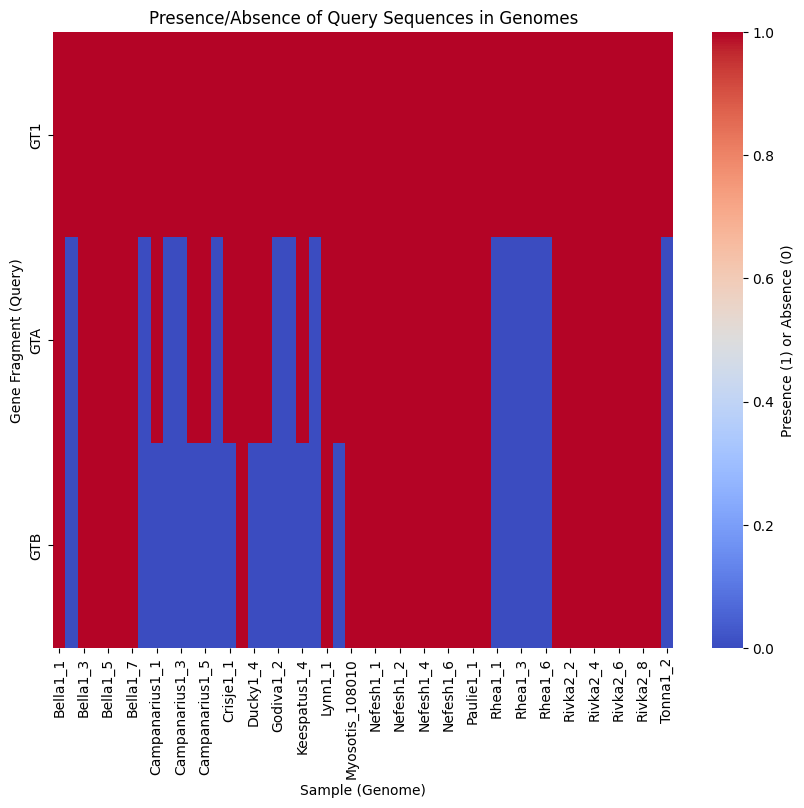

In [37]:
# Create a presence/absence matrix
presence_absence_matrix = df_all.pivot_table(index="Gene_fragment", columns="Sample", values="bitscore", aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(presence_absence_matrix, cmap="coolwarm", cbar_kws={'label': 'Presence (1) or Absence (0)'})
plt.title("Presence/Absence of Query Sequences in Genomes")
plt.xlabel("Sample (Genome)")
plt.ylabel("Gene Fragment (Query)")
plt.show()

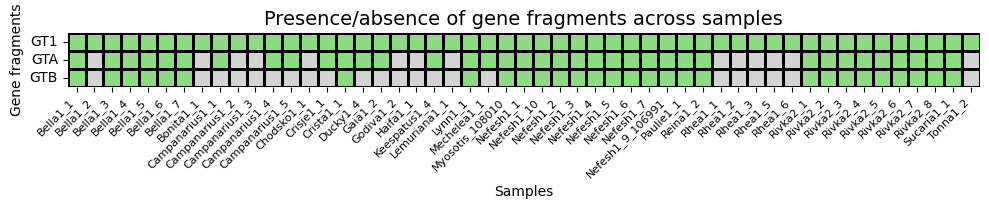

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_all = pd.read_csv("../results/gene_cluster_genes/gene_fragments_result.tsv", sep="\t")
presence_absence = df_all.pivot_table(index="Sample", columns="Gene_fragment", 
                                  values="bitscore", aggfunc=lambda x: 1 if len(x) > 0 else 0, fill_value=0)

# Set up the color map (green for presence, grey for absence)
cmap = sns.color_palette(['#d3d3d3', '#8bdb7f'])  # grey for absence, green for presence

# Create the heatmap
plt.figure(figsize=(10, 6))
presence_absence_heatmap = sns.heatmap(presence_absence.T, cmap=cmap, linewidths=1, linecolor='black', 
            cbar=False, square=True, annot=False, yticklabels=True, xticklabels=True)

plt.title('Presence/absence of gene fragments across samples', fontsize=14)
plt.xlabel('Samples')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.ylabel('Gene fragments')

# Show the plot
plt.tight_layout()
plt.show()

# heatmap + fragments

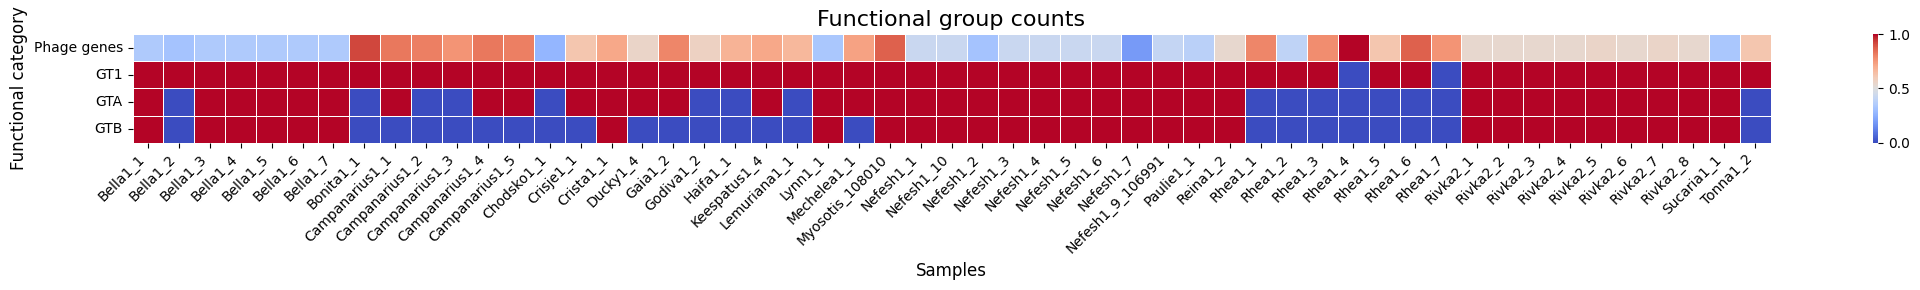

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def concatenate_dataframes(presence_absence, functional_group_totals):
    # Transpose and set index names
    presence_absence_T = presence_absence.T
    presence_absence_T.index.name = 'Gene'
    functional_group_totals.index.name = 'Category'
    
    # Concatenate with alignment and fill missing values
    combined = pd.concat([presence_absence_T, functional_group_totals], axis=0).fillna(0)
    
    # Assign an overall index name, if needed
    combined.index.name = 'Functional Group'
    combined = combined.sort_index(axis=1)
    return combined

# Load and prepare data as before
merged_gene_data = pd.read_excel("merged_gene_data_func_filtered_mge.xlsx")
sample_columns = merged_gene_data.columns[merged_gene_data.columns.get_loc('Bella1_1'):merged_gene_data.columns.get_loc('Tonna1_2') + 1]

functional_group_totals = merged_gene_data.groupby('functional_category')[sample_columns].count()
functional_group_totals = functional_group_totals[functional_group_totals.index == "Phage genes"]

# Add missing samples
# for sample in ['Rhea1_4', 'Rhea1_7']:
#     if sample not in presence_absence.columns:
#         presence_absence[sample] = 0

# Concatenate in function
sample_df = concatenate_dataframes(presence_absence, functional_group_totals)

# Proceed with plotting
plt.figure(figsize=(22, 3))
sample_df_sorted = sample_df.sort_values(by=sample_df.columns[0], ascending=False)
sample_df_n = sample_df_sorted.div(sample_df_sorted.max(axis=1), axis=0) # normalize rows
sns.heatmap(sample_df_n, cmap="coolwarm", annot=False, fmt=".0f", linewidths=.5)
plt.title("Functional group counts", fontsize=16)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Functional category", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.savefig("../results/gene_cluster_genes/gene_fragments_phage.png")

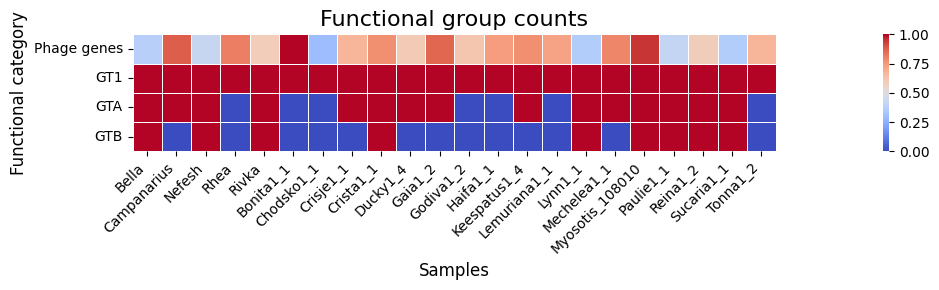

In [7]:
"""
Group the intra individual samples before doing a Spearman rank correlation test to avoid inflating the numbers. 
Majority vote for GT fragments and mean of Phage genes
"""

from scipy.stats import spearmanr

intra_individuals = ["Bella", "Campanarius", "Nefesh", "Rhea", "Rivka"]
grouped_results = {}

# Process intra-individuals by calculating majority and mean
for prefix in intra_individuals:
    # Filter columns that match the prefix
    group_df = sample_df.filter(regex=f"^{prefix}")
    
    # Calculate the majority value for GT1, GTA, and GTB
    majority_values = group_df.loc[["GT1", "GTA", "GTB"]].mode(axis=1)[0]
    
    # Calculate the mean for Phage genes
    phage_mean = group_df.loc["Phage genes"].mean()
    
    # Combine results
    grouped_results[prefix] = pd.Series(
        data=list(majority_values) + [phage_mean],
        index=["GT1", "GTA", "GTB", "Phage genes"]
    )

# Add columns for individuals not in intra-individuals without modification
for col in sample_df.columns:
    if not any(col.startswith(prefix) for prefix in intra_individuals):
        grouped_results[col] = sample_df[col]
# Convert the results to a DataFrame for better readability
grouped_summary_df = pd.DataFrame(grouped_results)

# display(grouped_summary_df.T)
plt.figure(figsize=(22, 3))
grouped_summary_df_sorted = grouped_summary_df.sort_values(by=grouped_summary_df.columns[0], ascending=False)
grouped_df_n = grouped_summary_df_sorted.div(grouped_summary_df_sorted.max(axis=1), axis=0) 
sns.heatmap(grouped_df_n, cmap="coolwarm", linewidths=.5, square=True)
plt.title("Functional group counts", fontsize=16)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Functional category", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

# Spearman correlation between all GT fragments and Phage genes
# print("\nSpearman Correlation (Ranks):")
grouped_summary_df_T = grouped_summary_df.T
correlation, p_value = spearmanr(grouped_summary_df_T[["GTA", "GTB", "Phage genes"]]) # , grouped_summary_df_T["Phage genes"]
# print(f"Spearman correlation: {correlation:.3f}, p-value: {p_value:.3f}")
# print(f"Spearman correlation: {correlation}, p-value: {p_value}")

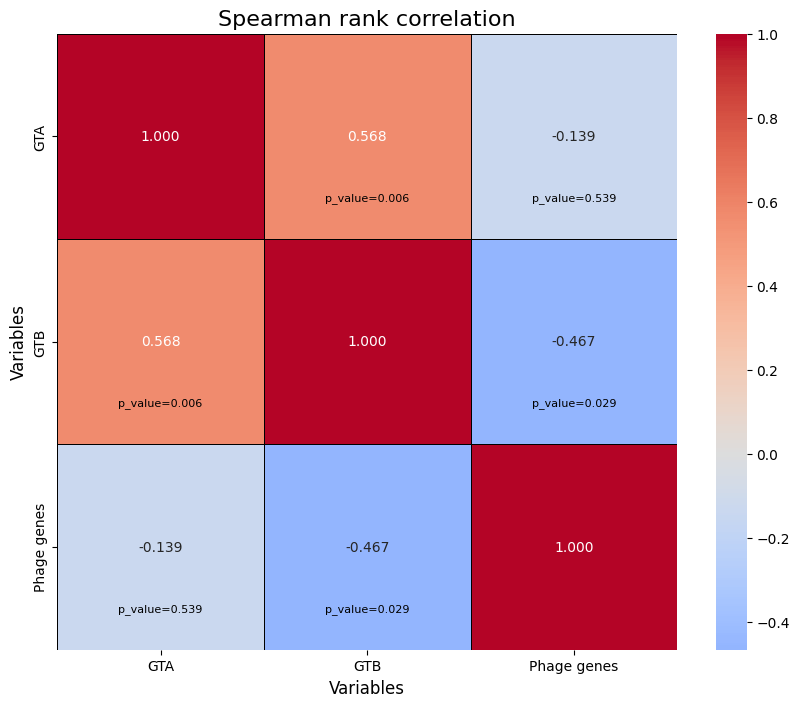

In [6]:
# Calculate Spearman correlation
correlation_matrix, p_value_matrix = spearmanr(grouped_summary_df_T[["GTA", "GTB", "Phage genes"]])

# Set up the plot
plt.figure(figsize=(10, 8))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', cbar=True, 
            xticklabels=grouped_summary_df_T.columns[1:], yticklabels=grouped_summary_df_T.columns[1:], annot_kws={"size": 10}, 
            linewidths=0.5, linecolor='black', center=0)

# Annotate with both correlation and p-values
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if i != j:  # To avoid annotating the diagonal twice
            plt.text(j + 0.5, i + 0.8, f"p_value={p_value_matrix[i, j]:.3f}", 
                     ha="center", va="center", color="black", fontsize=8)

# Set the title and labels
plt.title('Spearman rank correlation', fontsize=16)
plt.xlabel('Variables', fontsize=12)
plt.ylabel('Variables', fontsize=12)

# Display the plot
plt.show()

[-0.13855847 -0.46670479]
[0.5385951  0.02855094]
Correlation: -0.139, p-value: 0.539
Correlation: -0.467, p-value: 0.029
[-0.13855847 -0.46670479]


<Axes: >

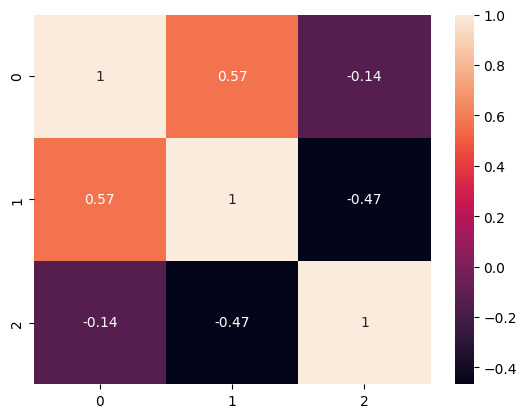

In [5]:
correlations_with_phage_genes = correlation[:2, 2]  # First three rows, last column
p_values_with_phage_genes = p_value[:2, 2]
print(correlations_with_phage_genes)
print(p_values_with_phage_genes)
# Combine correlation and p-value into a single array of strings
combined_results = [
    f"Correlation: {correlations_with_phage_genes[i]:.3f}, p-value: {p_values_with_phage_genes[i]:.3f}"
    for i in range(len(correlations_with_phage_genes))
]

# Print results
for result in combined_results:
    print(result)
print(correlation[:2,2])
sns.heatmap(correlation, annot=True)